In [377]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [485]:
#Define Neural Network Model
def nn_model(input_shape = (3,), layers = None):
    input_ = tf.keras.layers.Input(shape = input_shape)
    x = tf.keras.layers.Dense(layers[0], activation = 'tanh')(input_)
    for layer in layers[1:-1]:
        x = tf.keras.layers.Dense(layer, activation = 'tanh')(x)
    output = tf.keras.layers.Dense(layers[-1])(x)
    model = tf.keras.Model(input_, output)
    return model
    
#Define PDE Layers
def compute_pde(model, x, y, t, alpha = 1e-4):
    with tf.GradientTape(persistent = True) as tape:
        tape.watch([x,y,t])
        u = model(tf.stack([x,y,t], axis = 1))
        u_x = tape.gradient(u,x)
        u_y = tape.gradient(u,y)
        u_t = tape.gradient(u,t)
    u_xx = tape.gradient(u_x, x)
    u_yy = tape.gradient(u_y, y)
    del tape
    
    f = u_t - alpha*(u_xx+u_yy)
    return f

#Compute Loss Function of U
def compute_loss(model, x, x_bound, y, y_bound, t,
                 t_bound, u_init, u_bounds, u_bounds_x, u_bounds_y):
    # PDE Loss
    f = compute_pde(model, x, y, t)
    mse_f = tf.reduce_mean(tf.square(f))
    
    #Initial Loss -- u(x,t=0)
    t_init = tf.zeros_like(x)
    u_init_p = model(tf.stack([x, y, t_init], axis = 1))
    mse_init = tf.reduce_mean(tf.square(u_init_p-u_init))
    
    #Boundary Loss (Drichlet and Neumann)
    mse_drichlet = 0
    mse_neumann = 0
    for i in range(x_bound.shape[0]):
        xi, yi, ti = x_bound[i], y_bound[i], t_bound[i]
        
        #Drichlet Loss
        u_bound = u_bounds[i]
        u_bound_x = u_bounds_x[i]
        u_bound_y = u_bounds_y[i]
        u_bound_p = model(tf.stack([xi,yi,ti], axis = 1))
        mse_drichlet = tf.reduce_mean(tf.square(u_bound-u_bound_p))
        
        #Neumann Loss
        with tf.GradientTape(persistent = True) as tape:
            tape.watch([xi, yi])
            u_bound_p = model(tf.stack([xi, yi, ti], axis=1))
            u_x = tape.gradient(u_bound_p, xi)
            u_y = tape.gradient(u_bound_p, yi)
            
            mse_neumann += tf.reduce_mean(tf.square(u_bound_x-u_x))
            mse_neumann += tf.reduce_mean(tf.square(u_bound_y-u_y))
            
    mse_total = mse_f+mse_init+mse_drichlet+mse_neumann
    return mse_total

# Training Step
@tf.function
def train_step(model, optimizer, x, x_bound, y, y_bound, t,
                 t_bound, u_init, u_bounds, u_bounds_x, u_bounds_y):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x, x_bound, y, y_bound, t,
                 t_bound, u_init, u_bounds, u_bounds_x, u_bounds_y)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss


In [486]:
#Initializing X,Y,T
dim = 100
x = np.linspace(0,1,dim, dtype = np.float32)
y = np.linspace(0,1,dim, dtype = np.float32)
t = np.linspace(0,10,dim, dtype = np.float32).reshape(-1,1)

X,Y = np.meshgrid(x,y)
u_init = np.zeros_like(X)
u_init[25:75, 25:75] = 1.


X_bound = np.c_[X[:,0], X[:,-1], X[0,:], X[-1,:]].T
Y_bound = np.c_[Y[:,0], Y[:,-1], Y[0,:], Y[-1,:]].T
T_bound = np.tile(t,(4)).T
u_bound = np.zeros_like(X_bound)
u_bound_x = np.zeros_like(X_bound)
u_bound_y = np.zeros_like(Y_bound)

In [487]:
X = tf.constant(X.reshape(-1,1), dtype=tf.float32)
Y = tf.constant(Y.reshape(-1,1), dtype = tf.float32)
T_ = tf.constant(np.tile(t,(dim,1)), dtype = tf.float32)
u_init = tf.constant(u_init.reshape(-1,1), dtype = tf.float32)

X_bound = tf.constant(np.expand_dims(X_bound,-1), dtype = tf.float32)
Y_bound = tf.constant(np.expand_dims(Y_bound,-1), dtype = tf.float32)
T_bound = tf.constant(np.expand_dims(T_bound,-1), dtype = tf.float32)
u_bound = tf.constant(np.expand_dims(u_bound,-1), dtype = tf.float32)
u_bound_x = tf.constant(np.expand_dims(u_bound_x,-1), dtype = tf.float32)
u_bound_y = tf.constant(np.expand_dims(u_bound_y,-1), dtype = tf.float32)

In [488]:
# Build and compile the model
model = nn_model(input_shape=(3,), layers = [128,64,64,1])
optimizer = tf.keras.optimizers.Adam()
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor = 'loss', patience = 100, min_delta = 1e-4,
    verbose = 1, mode = 'min')

early_stop.set_model(model)
early_stop.on_train_begin()
# Training loop
epochs = 7000
for epoch in range(epochs):
    loss = train_step(model, optimizer, X, X_bound, Y, Y_bound,
                      T_, T_bound, u_init, u_bound, u_bound_x, u_bound_y)
    logs= {'loss': loss}
    early_stop.on_epoch_end(epoch, logs)
    if early_stop.stopped_epoch > 0:
        print(f'Early Stopping at epoch {epoch}')
        break
print(f'Loss: {loss.numpy()}')
early_stop.on_train_end()

Early Stopping at epoch 5448
Loss: 0.015015000477433205
Epoch 5449: early stopping


In [489]:
# Predict and Visualization
x_new = np.linspace(0,1,100).reshape(-1,1)
y_new = np.linspace(0,1,100).reshape(-1,1)
t_new = np.linspace(0,10,100).reshape(-1,1)

X_new, Y_new, T_new = np.meshgrid(x_new, y_new, t_new, indexing = 'ij')
shape = X_new.shape

X_new_tf = tf.constant(X_new.reshape(-1,1), dtype=tf.float32)
Y_new_tf = tf.constant(Y_new.reshape(-1,1), dtype = tf.float32)
T_new_tf = tf.constant(T_new.reshape(-1,1), dtype=tf.float32)

input_new = tf.concat([X_new_tf, Y_new_tf, T_new_tf], axis=1)
u_pred = model.predict(input_new)
u_pred = u_pred.reshape(shape)

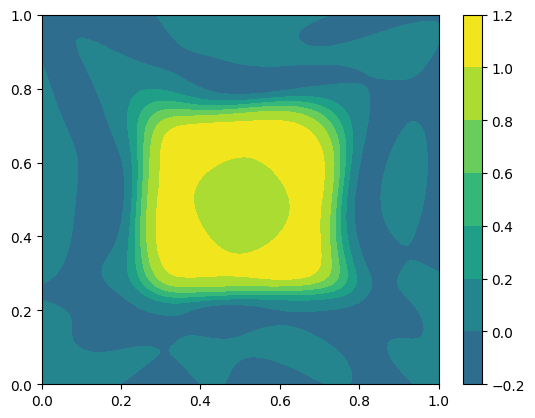

In [490]:
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots()
vmin = u_pred.min(); vmax = u_pred.max()
contour = ax.contourf(X_new[:,:,0], Y_new[:,:,0], u_pred[:,:,0], vmin=vmin, vmax=vmax)

def update(frame):
    ax.clear()  # Clear previous plot # Reset y-axis limits
    contour = ax.contourf(X_new[:,:,0], Y_new[:,:,0], u_pred[:,:,frame], 
                          vmin = vmin, vmax = vmax)
    return contour

num_frames = u_pred.shape[-1]
ani = FuncAnimation(fig, update, frames=num_frames, interval=200)

cbar = plt.colorbar(contour, ax=ax)

plt.show()

In [491]:
ani.save('animation_contour_10k.gif', writer='Pillow', fps=10)

MovieWriter Pillow unavailable; using Pillow instead.
